## 1. Download Precipitation and Isotope NEON data

In [ ]:
# Load rpy2 so R scripts can run within jupyter notebook - run this one time
%load_ext rpy2.ipython

In [ ]:
%%R 
# This rpy2 'Rmagic' command allows to run the entire cell block as R code

# Install R packages - run this one time
install.packages("neonUtilities")
install.packages('openxlsx')


In [ ]:
%%R

# Load required libraries - run this every time
library(neonUtilities)
library(openxlsx)

# creating a list of site names: this will iterate through all sites, or can be adapted to only download sites of interest
siteNames <- c("DELA", "LENO", "TALL", "BARR", "BONA", "HEAL", "TOOL", "SRER", "SJER", "CPER", "NIWO", "RMNP",
             "STER", "OSBS", "JERC", "PUUM", "KONZ", "UKFS", "SERC", "HARV", "UNDE", "BART", "NOGP", "WOOD", "OAES",
              "GUAN", "GRSM", "ORNL", "CLBJ", "MOAB", "ONAQ", "BLAN", "MLBS", "SCBI", "WREF", "STEI", "YELL")

for (val in siteNames) {
    siteName <- val
    
    # download isotope data
    IsoData <- loadByProduct(dpID="DP1.00038.001", site=siteName)
    list2env(IsoData, .GlobalEnv)
    destination <- paste("IsoData/", siteName, "IsoData.xlsx", sep="") # moves into IsoData folder and creates file name
    write.xlsx(wdi_isoPerSample, destination, row.names=F)
    
    # download precip data - primary data if available, secondary data if not
    PrecipData <- loadByProduct(dpID="DP1.00006.001", site=siteName)
    list2env(PrecipData, .GlobalEnv)
    destination <- paste("PrecipData/", siteName, "PrecipData.xlsx", sep="") # moves into PrecipData folder and creates file name
    if (exists("PRIPRE_30min")) {
        write.xlsx(PRIPRE_30min, destination, row.names=F)
    } else {
        write.xlsx(SECPRE_30min, destination, row.names=F)
    }
}

## 2. Generate a downscaled daily data product at each NEON site

In [1]:
## Python Import Statements
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn import metrics

ROOTDIR = os.getcwd() # Home directory
CODEDIR = ROOTDIR + '/CODE/' # Code directory
DATADIR = ROOTDIR + '/DATA/' # Data directory

os.chdir(CODEDIR) # Change directory
import changeTimes
import getRunningMean
import conditional_copula_ts
import iso_sine_signal
import calcSiteStats

os.chdir(ROOTDIR) # Change directory

In [2]:
# User defined variables
sitenames = ["DELA", "LENO", "TALL", "BONA", "HEAL", "TOOL", "SRER", "SJER", "CPER", "NIWO", "RMNP", "STER",
             "OSBS", "JERC", "PUUM", "KONZ", "UKFS", "SERC", "HARV", "UNDE", "BART", "NOGP", "WOOD", "OAES",
             "GUAN", "GRSM", "ORNL", "CLBJ", "MOAB", "ONAQ", "BLAN", "MLBS", "SCBI", "WREF", "STEI", "YELL"]
ensemble_size = 10

In [3]:
## This iterates through all the sites in 'sitenames'
amplitude = []
correlation = []

for s in np.arange(len(sitenames)):
    # 30min Precipitation Data
    df_P30 = pd.read_excel(DATADIR+'PrecipData/'+str(sitenames[s])+'PrecipData.xlsx',index=False)
    df_P30 = changeTimes.change_Pdata(df_P30)
    
    # Sum to Daily Precipitation Amounts
    # checks for primary precip data
    if 'priPrecipBulk' in df_P30:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)



        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['priPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # uses secondary precip data
    else:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['secPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)



        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['secPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    
    '''
    Step 1 - Remove seasonal time series component (Section 2.b.1)
    '''
    
    # Define Sine Wave Functions
    df_iso = df_iso.sort_values('DateTime')
    df_iso = df_iso.dropna(subset=['Total P'])
    tsX = df_iso['FracYear'].values 
    tsP = df_iso['Total P'].values
    tsO = df_iso['d18OWater'].values
    tsH = df_iso['d2HWater'].values   

    dayslist = []
    for dt in np.arange(len(df_iso['DateTime'])):
        dayslist.append((df_iso['DateTime'].iloc[dt] - df_iso['DateTime'].iloc[0]).days)
    dayslist = np.array(dayslist)

    # lambda is precipitation frequency (see Eq. 4)
    p_events = df_iso[df_iso['Total P'].notna()]
    lamda = len(p_events['Total P'])/((daily_P.index.max() - daily_P.index.min()).days) 

    params1, params2 = iso_sine_signal.sine_params(sitenames[s],14,tsX,tsP,tsH,tsO) # 14 = biweekly sample, sample frequency
    tsY_sine_wave = iso_sine_signal.sine_func(tsX, params1[0],params1[1],params1[2]) # solve for amplitude, phase, offset
    adj_2H = np.array((tsH - tsY_sine_wave))    # remove seasonality from time series                       

    tsY_sine_wave = iso_sine_signal.sine_func(tsX, params2[0],params2[1],params2[2])     
    adj_18O = np.array((tsO - tsY_sine_wave)) 
    
    amplitude.append(params1[0])
    
    # Get biweekly site stats of stochastic component
    biweekly_stats = np.array([[np.mean(tsP), np.mean(adj_2H), np.mean(adj_18O)],
                     [np.std(tsP), np.std(adj_2H), np.std(adj_18O)],
                     [sp.stats.pearsonr(tsP,adj_2H)[0], sp.stats.pearsonr(tsP,adj_18O)[0], sp.stats.pearsonr(adj_2H,adj_18O)[0]]])

    correlation.append(sp.stats.pearsonr(tsP,adj_18O)[0])
    
    '''
    Step 2 - Predict daily statistics from biweekly time series (Section 2.b.2) Now we will need to aggregate the 
    stochastic biweekly time series - i.e. calculated weighed running means at biweekly (14-day), 28-day, 42-day, 
    56-day and 84-day intervals    
    '''

    # function defining calculated statistics on time series
    site_stats = [[sitenames[s], 14, lamda,
                   biweekly_stats[0,0], biweekly_stats[0,1], biweekly_stats[0,2],
                   biweekly_stats[1,0], biweekly_stats[1,1], biweekly_stats[1,2],
                   biweekly_stats[2,0], biweekly_stats[2,1], biweekly_stats[2,2]]]
    site_stats_check = len(site_stats)

    for n in np.arange(28,85,14):
        xday_Hb, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsH),np.array(tsP),tsX,n)
        xday_Ob, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsO),np.array(tsP),tsX,n)  

        xday_Xb = np.array(xday_Xb)
        xday_Pb = np.array(xday_Pb)
        xday_Hb = np.array(xday_Hb)
        xday_Ob = np.array(xday_Ob)   

        params1a, params2a = iso_sine_signal.sine_params(sitenames[s],n,xday_Xb,xday_Pb,xday_Hb,xday_Ob)

        tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params1a[0],params1a[1],params1a[2])
        adj_2Hb = np.array((xday_Hb - tsY_sine_wave))                           

        tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params2a[0],params2a[1],params2a[2])     
        adj_18Ob = np.array((xday_Ob - tsY_sine_wave))
        
        if len(xday_Pb)>2 and len(adj_2Hb)>2 and len(adj_18Ob)>2:
            calcSiteStats.main(site_stats,sitenames[s],lamda,n,xday_Pb,adj_2Hb,adj_18Ob)
            
    if len(site_stats)==site_stats_check:
        print("Site {} does not contain sufficient data.".format(sitenames[s]))
        
    else:
        ### the stats are labeled with 'B' here because they are of the stochastic component - not the original time series
        Site_Stats = pd.DataFrame(site_stats, columns = ['site','agglev','lambda','PmuB','HmuB','OmuB','PsigB',
                                                         'HsigB','OsigB','PHpB','POpB','HOpB'])
    
        ### Now we apply equation 4
        Hi = [] ; Oi = [] # estimated 1-day parameters
        H_a = [] ; O_a = [] # a term

        xaxis = np.array(Site_Stats['agglev'].values)
        yaxis1 = np.array(Site_Stats['HsigB'].values)
        yaxis2 = np.array(Site_Stats['OsigB'].values)

        def eq4(x,a,b):
            return b/(x*lamda)**a

        bounds = [[0.2,yaxis1[0]],[0.5,np.inf]]
        p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis1, p0 = [0.3,yaxis1[0]], bounds=bounds)

        Hi.append(float(p1[1]))
        H_a.append(p1[0])

        bounds = [[0.2,yaxis2[0]],[0.5,np.inf]]
        p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis2,  p0 = [0.3,yaxis2[0]], bounds=bounds)

        Oi.append(float(p1[1]))
        O_a.append(p1[0])
    
        
        '''
        Step 3 - Generate daily time series with estimated statistcs (Section 2.b.2)
        Step 4 - Add in seasonal time series component (Section 2.b.2)
        '''
    
        H_scale = np.sort(np.array(adj_2H) * Hi / Site_Stats['HsigB'].iloc[0])
        O_scale = np.sort(np.array(adj_18O) * Oi / Site_Stats['OsigB'].iloc[0])

        copula_stats = np.matrix([[0, 0, 0], [np.std(tsP), Hi, Oi],
                                    [Site_Stats['PHpB'].iloc[0], 
                                     Site_Stats['POpB'].iloc[0],
                                     Site_Stats['HOpB'].iloc[0]]])    

        for num in np.arange(1,ensemble_size+1):
            new_ts = conditional_copula_ts.main(daily_P['Total P'],copula_stats,H_scale,O_scale)
            y = np.array([np.array(xi) for xi in new_ts])   

            # Add back in n-day sine function here:
            tsH_daily = y[:,0] + iso_sine_signal.sine_func(daily_P['FracYear'], params1[0],params1[1],params1[2])    
            tsO_daily = y[:,1] + iso_sine_signal.sine_func(daily_P['FracYear'], params2[0],params2[1],params2[2])
        
            columnA = 'd2H_'+str(num)
            columnB = 'd18O_'+str(num)
            daily_P[columnA] = tsH_daily
            daily_P[columnB] = tsO_daily 

        daily_P.to_csv(ROOTDIR+'/OUTPUT/'+sitenames[s]+'_daily_timeseries.csv')


/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/linds

## 3. visualize output - i.e. time series plots and dual isotope plots

In [4]:
OUTPUTDIR = ROOTDIR + '/OUTPUT/' # Output directory
os.chdir(OUTPUTDIR) # Change directory

# User input
sitename = "ONAQ"
start_date = '01-01-2019'
end_date = '12-31-2019'

# import data based on selected dates
df_timeseries = pd.read_csv(str(sitename)+'_daily_timeseries.csv')
df_timeseries['DateTime'] = pd.to_datetime(df_timeseries['DateTime'])
mask = (df_timeseries['DateTime'] >= start_date) & (df_timeseries['DateTime'] <= end_date)
df_timeseries = df_timeseries.loc[mask]

# assigning variables
t = df_timeseries['DateTime']
P = df_timeseries['Total P']
d2H = df_timeseries['d2H_1']
d18O = df_timeseries['d18O_1']

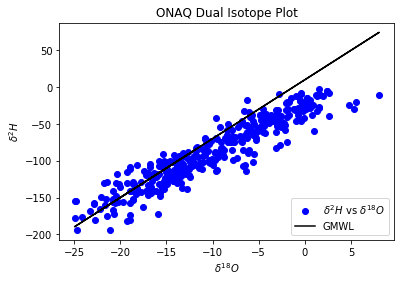

In [5]:
# creating a dual isotope plot

# define GMWL
GMWL = 8*d18O + 10

# create plot
plt.plot(d18O, d2H, 'o', color='blue', label="$\delta^{2}H$ vs $\delta^{18}O$")
plt.plot(d18O, GMWL, color='black', label="GMWL")
plt.title(str(sitename)+" Dual Isotope Plot")
plt.xlabel("$\delta^{18}O$")
plt.ylabel("$\delta^{2}H$")
plt.legend(loc="lower right")

/Users/lindseyspencer/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


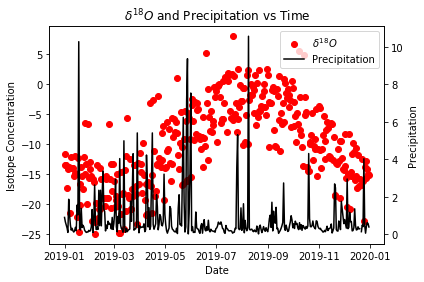

In [6]:
# creating an isotope and precipitation vs time plot

# d18O plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, d18O, 'o', color='red', label='$\delta^{18}O$')
ax2.plot(t, P, color='black', label='Precipitation')

ax1.set_title('$\delta^{18}O$ and Precipitation vs Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Isotope Concentration')
ax2.set_ylabel('Precipitation')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.savefig(ROOTDIR+'/FIGURES/'+'d18O_Plot', transparent=True)

# d2H plot
#fig, ax3 = plt.subplots()
#ax4 = ax3.twinx()

#ax3.plot(t, d2H, 'o', color='blue', label='$\delta^{2}H$')
#ax4.plot(t, P, color='black', label='Precipitation')

#ax3.set_title('$\delta^{2}H$ and Precipitation vs Time')
#ax3.set_xlabel('Date')
#ax3.set_ylabel('Isotope Concentration')
#ax4.set_ylabel('Precipitation')

#lines3, labels3 = ax3.get_legend_handles_labels()
#lines4, labels4 = ax4.get_legend_handles_labels()
#ax4.legend(lines3 + lines4, labels3 + labels4, loc=0)

## 4. Sort data to confirm statistics

In [7]:
# Site list
sitenames = ["DELA", "LENO", "TALL", "BONA", "HEAL", "TOOL", "SRER", "SJER", "CPER", "NIWO", "RMNP", "STER",
             "OSBS", "JERC", "PUUM", "KONZ", "UKFS", "SERC", "HARV", "UNDE", "BART", "NOGP", "WOOD", "OAES",
             "GUAN", "GRSM", "ORNL", "CLBJ", "MOAB", "ONAQ", "BLAN", "MLBS", "SCBI", "WREF", "STEI", "YELL"]
daily_hat = []

## This iterates through all the sites in 'sitenames'
for s in np.arange(len(sitenames)):
    # 30min Precipitation Data
    df_P30 = pd.read_excel(DATADIR+'PrecipData/'+str(sitenames[s])+'PrecipData.xlsx',index=False)
    df_P30 = changeTimes.change_Pdata(df_P30)
    
    # Sum to Daily Precipitation Amounts
    # checks for primary precip data
    if 'priPrecipBulk' in df_P30:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)


        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['priPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # uses secondary precip data
    else:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['secPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)


        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['secPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # Biweekly Time Series
    df_iso = df_iso.sort_values('DateTime')
    df_iso = df_iso.dropna(subset=['Total P'])
    
    # Beginning and End of time series
    start_date = df_iso['DateTime'].iloc[0]
    end_date = df_iso['DateTime'].iloc[-1]
    
    # Normalize = all days start at midnight
    daily_series = pd.date_range(start=start_date, end=end_date, normalize=True)
    # Remove timestamp -> index is only the date
    df_sub = df_iso.set_index(df_iso['DateTime'].dt.date)
    daily_series = daily_series.date
    
    # Make DataFrame of stats between dates
    for n in np.arange(len(daily_series)-14):
        mask = (df_sub.index >= daily_series[n]) & (df_sub.index < daily_series[n+14])
        df_temp = df_sub.loc[mask]
        
        if len(df_temp['Total P']) == 1:
            daily_hat.append([sitenames[s],daily_series[n], daily_series[n+14],len(df_temp['d18OWater']),
                              (df_temp['Total P'].values),(df_temp['d2HWater'].values),(df_temp['d18OWater'].values)])

daily_hat = pd.DataFrame(daily_hat,columns=('sitename','start_date','end_date','count','P','H','O'))

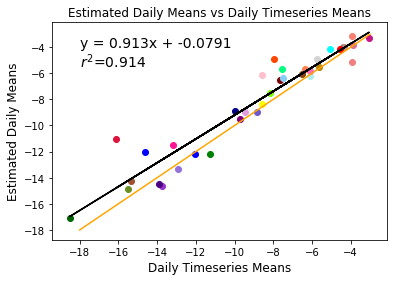

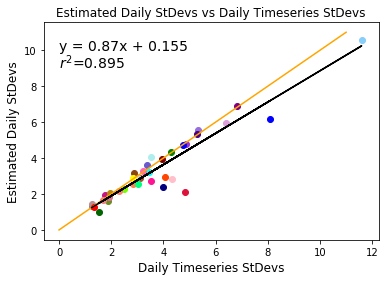

In [12]:
mu = []
mu_hat = []
sigma = []
sigma_hat = []

# calculating means and standard deviations
for i in np.arange(len(sitenames)):
    # calc mu and sigma from synthetic daily series
    sitename = sitenames[i]
    df_daily = pd.read_csv(str(sitename)+'_daily_timeseries.csv')
    mean = np.mean(df_daily['d18O_1'])
    std = np.std(df_daily['d18O_1'])
    mu.append(mean)
    sigma.append(std)
    
    #calc mu hat and sigma hat
    df_index = daily_hat['sitename'] == sitenames[i]
    df_sub = daily_hat[df_index]
    mean_hat = np.mean(df_sub['O'])
    std_hat = np.std(df_sub['O'])
    mu_hat.append(mean_hat)
    sigma_hat.append(std_hat)

# convert all data to np arrays
mu = np.array(mu)
mu_hat = np.array(mu_hat)
mu_hat = mu_hat.flatten() # flattens 2d to 1d to match the rest
sigma = np.array(sigma)
sigma_hat = np.array(sigma_hat)

# establishing colors for plots
colors = ['gray', 'rosybrown', 'red', 'sienna', 'olivedrab', 'darkgreen', 'paleturquoise', 'navy', 'blue',
         'mediumpurple', 'darkorchid', 'plum', 'mediumvioletred', 'palevioletred', 'lightcoral', 'maroon', 'coral',
         'darkgoldenrod', 'lawngreen', 'green', 'slateblue', 'deeppink', 'crimson', 'lightgray', 'salmon',
          'orangered', 'springgreen', 'aqua', 'lightskyblue', 'purple', 'hotpink', 'pink', 'saddlebrown',
         'yellow', 'blue', 'indigo']

# creating a 1:1 line
x_mu = np.arange(-18,-2)
y_mu = x_mu
x_sigma = np.arange(0,12)
y_sigma = x_sigma

# linear regression for means
slope_mu, intercept_mu, r_value_mu, p_value_mu, std_err_mu = stats.linregress(mu,mu_hat)
muModeled = slope_mu*mu + intercept_mu
r2_mu = r_value_mu**2

# linear regression for stds
slope_sigma, intercept_sigma, r_value_sigma, p_value_sigma, std_err_sigma = stats.linregress(sigma,sigma_hat)
sigmaModeled = slope_sigma*sigma + intercept_sigma
r2_sigma = r_value_sigma**2

# plotting means
for i in range (len(mu)):
    plt.scatter(mu[i], mu_hat[i], color=colors[i], label=sitenames[i])
plt.plot(x_mu, y_mu, color='orange')
plt.plot(mu, muModeled, color='black')
plt.title("Estimated Daily Means vs Daily Timeseries Means", fontsize = 12)
plt.xlabel("Daily Timeseries Means", fontsize = 12)
plt.ylabel("Estimated Daily Means", fontsize = 12)
plt.text(-18, -4, "y = {:.3}x + {:.3}".format(slope_mu, intercept_mu), fontsize=14)
plt.text(-18, -5.5, "$r^2$={:.3}".format(r2_mu), fontsize=14)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=6)
plt.savefig(ROOTDIR+'/FIGURES/'+'Means', transparent=True)
plt.show()

# plotting stdevs
for i in range (len(sigma)):
    plt.scatter(sigma[i], sigma_hat[i], color=colors[i], label=sitenames[i])
plt.plot(x_sigma, y_sigma, color='orange')
plt.plot(sigma, sigmaModeled, color='black')
plt.title("Estimated Daily StDevs vs Daily Timeseries StDevs", fontsize = 12)
plt.xlabel("Daily Timeseries StDevs", fontsize = 12)
plt.ylabel("Estimated Daily StDevs", fontsize = 12)
plt.text(0, 10, "y = {:.3}x + {:.3}".format(slope_sigma, intercept_sigma), fontsize=14)
plt.text(0, 9, "$r^2$={:.3}".format(r2_sigma), fontsize=14)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=6)
plt.savefig(ROOTDIR+'/FIGURES/'+'Stds', transparent=True)
plt.show()

In [7]:
# calculating RMSE

mse = metrics.mean_squared_error(mu_hat, mu)

rmse = np.sqrt(mse)

print(rmse)

1.4096715562442217


In [8]:
# calculating MBE

y_true = mu_hat
y_pred = mu
y_true = y_true.reshape(len(y_true),1)
y_pred = y_pred.reshape(len(y_pred),1)   
diff = (y_true-y_pred)
mbe = diff.mean()
print(mbe)

0.6937931880044291


In [27]:
os.chdir(ROOTDIR) # Change directory

# empty lists to add to
df_summary = []
site_name = []
site_ID = []
lat = []
long = []
start = []
end = []
records = []
H_mean = []
O_mean = []
H_std = []
O_std = []


# sorting through data
for i in np.arange(len(sitenames)):
    # basic site data from NEON file
    df_sites = pd.read_csv(DATADIR+'field-sites.csv')
    mask = (df_sites['Site ID'] == sitenames[i])
    df_sites = df_sites.loc[mask]
    site = df_sites['Site Name'].values[0]
    site_name.append(site)
    ID = df_sites['Site ID'].values[0]
    site_ID.append(ID)
    latitude = df_sites['Latitude'].values[0]
    lat.append(latitude)
    longitude = df_sites['Longitude'].values[0]
    long.append(longitude)
    
    # finding number of records, start and end dates
    df_iso = pd.read_excel(DATADIR+'/IsoData/'+str(sitenames[i])+'IsoData.xlsx')
    start_date = df_iso['setDate'].iloc[0]
    start.append(start_date)
    end_date = df_iso['collectDate'].iloc[-1]
    end.append(end_date)
    number = len(df_iso)
    records.append(number)
    
    # mean and std
    df_daily = pd.read_csv(OUTPUTDIR+str(sitenames[i])+'_daily_timeseries.csv')
    mean_H = np.mean(df_daily['d2H_1'])
    H_mean.append(mean_H)
    mean_O = np.mean(df_daily['d18O_1'])
    O_mean.append(mean_O)
    std_H = np.std(df_daily['d2H_1'])
    H_std.append(std_H)
    std_O = np.std(df_daily['d18O_1'])
    O_std.append(std_O)

# appending data to one list
df_summary.append(site_name)
df_summary.append(site_ID)
df_summary.append(lat)
df_summary.append(long)
df_summary.append(amplitude)
df_summary.append(correlation)
df_summary.append(start)
df_summary.append(end)
df_summary.append(records)
df_summary.append(H_mean)
df_summary.append(O_mean)
df_summary.append(H_std)
df_summary.append(O_std)

# creating pandas df
df_summary = pd.DataFrame(df_summary)
df_summary = df_summary.T
df_summary.columns = ['Site Name', 'Site ID', 'Latitude', 'Longitude', 'Amplitude', 'Correlation', 'Start Date', 'End Date',
                     'Number of Records', 'd2H Mean', 'd18O Mean', 'd2H Std', 'd18O Std']

# exporting df to CSV
df_summary.to_csv(ROOTDIR+'/FIGURES/'+'Site_Summary_Table.csv')